In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


(3983991, 6)
3983991 points


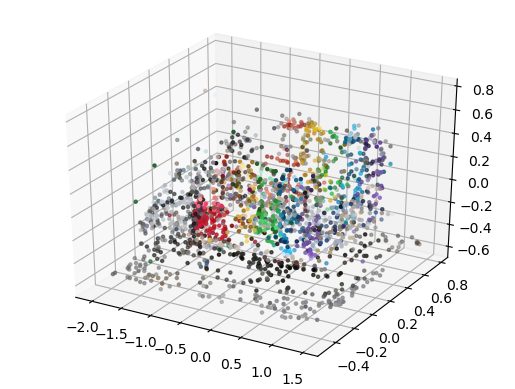

In [2]:
from plyfile import PlyData
plydata = PlyData.read('20230624_201539.ply')

data = plydata.elements[0].data

p = np.array([data['x'], data['y'], data['z']]).T
p -= np.mean(p, axis=0)
p /= np.mean(np.sum(p*p, axis=1)) ** 0.5
c = np.array([data['red'], data['green'], data['blue']], dtype=np.float32).T / 255.0 * 2 - 1
p = np.concatenate([p, c], axis=1)
print(p.shape)
N = p.shape[0]
print(N, 'points')

plt.figure()
ax = plt.axes(projection='3d')
i = np.arange(N)
np.random.shuffle(i)
i = i[:2000]
c = np.clip(0.5+0.5*p[i,3:],0,1)
ax.scatter(p[i,0], p[i,1], p[i,2], marker='.', c=c)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, ni, nh, no):
        super(Model, self).__init__()

        self.is_same = (ni == nh)
        self.activation = torch.sin
        self.layer1 = nn.Linear(ni, nh)
        self.layer2 = nn.Linear(nh, nh)
        self.layer3 = nn.Linear(nh, nh)
        self.layer4 = nn.Linear(nh, nh)
        self.layer5 = nn.Linear(nh, nh)
        self.layer6 = nn.Linear(nh, nh)
        self.layer7 = nn.Linear(nh, nh)
        self.layer8 = nn.Linear(nh, no)

    def forward(self, x):
        xm = self.activation(self.layer1(x))
        xm = self.activation(self.layer2(xm))+xm
        xm = self.activation(self.layer3(xm))+xm
        xm = self.activation(self.layer4(xm))+xm
        xm = self.activation(self.layer5(xm))+xm
        xm = self.activation(self.layer6(xm))+xm
        xm = self.activation(self.layer7(xm))+xm
        return self.layer8(xm)

NZ = 16
NH = 16
ND = 6

encoder = Model(ND, NH, NZ).to(device)
decoder = Model(NZ, NH, ND).to(device)

print(encoder)
print(decoder)

Model(
  (layer1): Linear(in_features=6, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=16, bias=True)
  (layer5): Linear(in_features=16, out_features=16, bias=True)
  (layer6): Linear(in_features=16, out_features=16, bias=True)
  (layer7): Linear(in_features=16, out_features=16, bias=True)
  (layer8): Linear(in_features=16, out_features=16, bias=True)
)
Model(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=16, bias=True)
  (layer5): Linear(in_features=16, out_features=16, bias=True)
  (layer6): Linear(in_features=16, out_features=16, bias=True)
  (layer7): Linear(in_features=16, out_features=16, bias=True)
  (layer8): Linear(in_features=16, out_f

In [7]:
def chamfer_distance(pc1, pc2):
    # Calculate pairwise distances
    pairwise_distances_pc1_pc2 = torch.cdist(pc1, pc2, p=2)
    pairwise_distances_pc2_pc1 = torch.cdist(pc2, pc1, p=2)

    # Find the nearest neighbors for each point
    nearest_neighbors_pc1 = torch.min(pairwise_distances_pc1_pc2, dim=1).values
    nearest_neighbors_pc2 = torch.min(pairwise_distances_pc2_pc1, dim=1).values

    # Calculate the Chamfer distance
    chamfer_loss = torch.mean(nearest_neighbors_pc1) + torch.mean(nearest_neighbors_pc2)

    return chamfer_loss


data = torch.tensor(p, dtype=torch.float32, device=device)

optimizer_e = torch.optim.Adam(
    encoder.parameters(),
    lr=0.001
)
optimizer_d = torch.optim.Adam(
    decoder.parameters(),
    lr=0.001
)

soboleng = torch.quasirandom.SobolEngine(dimension=NZ)

def rand_lds(n):
    u = soboleng.draw(n).to(device)
    return torch.erfinv(1.9999*(u-0.5))


batch_size = 2048

for batch_i in range(100000):
    i = torch.arange(0, batch_size, dtype=torch.int64, device=device)
    i = ((i + batch_i*batch_size) * 131407079) % len(data)

    x = data[i]
    z = encoder(x)
    y = decoder(z)
    y[:, 3:] = torch.tanh(y[:, 3:])
    loss_p = 1.0 * torch.mean(torch.abs(y[:,:3]-x[:,:3]))
    loss_c = 2.0 * torch.mean(torch.abs(y[:,3:]-x[:,3:]))
    loss_diff = loss_p + loss_c

    z = rand_lds(batch_size)
    y = decoder(z)
    y[:, 3:] = torch.tanh(y[:, 3:])
    loss_p = 1.0 * chamfer_distance(y[:,:3], x[:,:3])
    loss_c = 0.1 * chamfer_distance(y, x)

    loss = loss_diff + loss_p + loss_c

    encoder.zero_grad()
    decoder.zero_grad()
    loss.backward()
    optimizer_e.step()
    optimizer_d.step()

    if (batch_i+1) % 1000 == 0:
        print('%d diff %.4f, p %.4f, c %.4f, total %.4f' % (
            batch_i+1, loss_diff.item(), loss_p.item(), loss_c.item(), loss.item()))


1000 diff 0.0157, p 0.1057, c 0.0436, total 0.1649
2000 diff 0.0137, p 0.1098, c 0.0441, total 0.1675
3000 diff 0.0175, p 0.1064, c 0.0431, total 0.1670
4000 diff 0.0155, p 0.1063, c 0.0434, total 0.1652
5000 diff 0.0139, p 0.1061, c 0.0435, total 0.1634
6000 diff 0.0150, p 0.1062, c 0.0430, total 0.1642
7000 diff 0.0169, p 0.1082, c 0.0434, total 0.1685
8000 diff 0.0155, p 0.1044, c 0.0421, total 0.1620
9000 diff 0.0160, p 0.1070, c 0.0424, total 0.1654
10000 diff 0.0150, p 0.1067, c 0.0432, total 0.1650
11000 diff 0.0138, p 0.1050, c 0.0428, total 0.1616
12000 diff 0.0133, p 0.1067, c 0.0421, total 0.1621
13000 diff 0.0148, p 0.1053, c 0.0417, total 0.1617
14000 diff 0.0144, p 0.1024, c 0.0414, total 0.1583
15000 diff 0.0145, p 0.1041, c 0.0420, total 0.1605
16000 diff 0.0143, p 0.1023, c 0.0417, total 0.1583
17000 diff 0.0134, p 0.1010, c 0.0407, total 0.1551
18000 diff 0.0133, p 0.1039, c 0.0414, total 0.1585
19000 diff 0.0145, p 0.1029, c 0.0417, total 0.1591
20000 diff 0.0151, p 

(4096, 6)


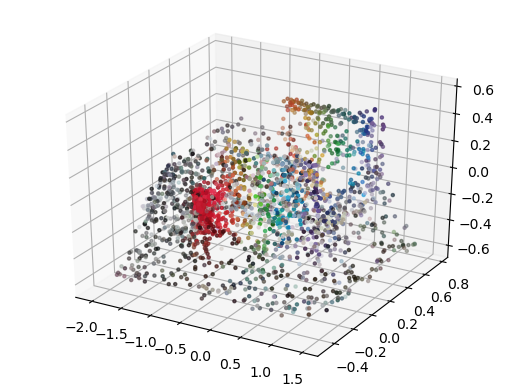

In [8]:
z = rand_lds(4096)

with torch.no_grad():
    y = decoder(z)

y = y.detach().cpu().numpy()
print(y.shape)

c = 0.5 + 0.5 * np.tanh(y[:, 3:])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], marker='.', c=c)
plt.show()

In [9]:
varname = "abcdefghijklmnopqrstuvwxyz"

print("N=2500")
print("I=\\left[0...N-1\\right]+0.5")

print("R\\left(u\\right)=\\sqrt{-2\\ln\\left(1-0.8u\\right)}")

varnames = [f"a_{{{i}}}" for i in range(NZ)]

assert NZ % 2 == 0

us = []
for i in range(NZ):
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
    u = "\\frac{I}{N}" if i==0 else "\\operatorname{mod}\\left(\\sqrt{"+str(primes[i-1])+"}I,1\\right)"
    us.append(u)

for i in range(NZ):
    # s = varnames[i] + "=R\\left(\\operatorname{random}\\left(N\\right),\\operatorname{random}\\left(N\\right)\\right)"
    u = us[2*(i//2)]
    v = us[2*(i//2)+1]
    s = varnames[i] + "=R\\left("+u+"\\right)\\"+['cos','sin'][i%2]+"\\left(2\\pi"+v+"\\right)"
    print(s)

layer = 0
params = list(decoder.parameters())
for layer in range(0, len(params)//2):
    w = params[2*layer]
    b = params[2*layer+1]
    # print(w.shape, b.shape)
    varnames1 = [f"{varname[layer+1]}_{{{i}}}" for i in range(len(b))]
    for i in range(len(b)):
        s = varnames1[i] + '='
        if 2*layer+2 < len(params):
            s += "\\sin\\left("
        for j in range(w.shape[1]):
            t = ("{:"+'+'*int(j>0)+".4g}").format(w[i][j])
            if 'e' not in t:
                s += t + varnames[j]
        t = ("{:"+'+'*int(j>0)+".4g}").format(b[i])
        if 'e' not in t:
            s += ("{:"+'+'*int(j>0)+".4g}").format(b[i])
        if 2*layer+2 < len(params):
            s += "\\right)"
        if layer > 0 and 2*layer+2 < len(params):
            s += '+'+varnames[i]
        print(s)
    varnames = varnames1

print('\\left('+','.join(varnames[:3])+'\\right)')
print(f"c=\\operatorname{{rgb}}\\left("
      f"128+128\\tanh\\left({varnames[3]}\\right),"
      f"128+128\\tanh\\left({varnames[4]}\\right),"
      f"128+128\\tanh\\left({varnames[5]}\\right)\\right)")

N=2500
I=\left[0...N-1\right]+0.5
R\left(u\right)=\sqrt{-2\ln\left(1-0.8u\right)}
a_{0}=R\left(\frac{I}{N}\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{2}I,1\right)\right)
a_{1}=R\left(\frac{I}{N}\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{2}I,1\right)\right)
a_{2}=R\left(\operatorname{mod}\left(\sqrt{3}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{5}I,1\right)\right)
a_{3}=R\left(\operatorname{mod}\left(\sqrt{3}I,1\right)\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{5}I,1\right)\right)
a_{4}=R\left(\operatorname{mod}\left(\sqrt{7}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{11}I,1\right)\right)
a_{5}=R\left(\operatorname{mod}\left(\sqrt{7}I,1\right)\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{11}I,1\right)\right)
a_{6}=R\left(\operatorname{mod}\left(\sqrt{13}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{17}I,1\right)\right)
a_{7}=R\left(\operatorname{mod}\left(\sqrt{13}I,1\right)\right)\sin\left(2\pi\operatorname{mod